## Contrastive Learning: Effective Anomaly Detection with Auto-Encoders

To exemplify how this works, let's try to solve Kaggle's Credit Card Fraud Detection problem. In this challenge we have a datasets containing transactions made by credit cards in September 2013 by European cardholders. From a total of 284,807 transactions, 492 are frauds, meaning that the dataset is highly unbalanced. The positive class (frauds) account for 0.172% of all transactions.

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from autoencoders import Autoencoder

from helper import plot_loss_by_epoch, plot_reconstructuion_err_by_class, plot_precision_recall_curves

In [63]:
df = pd.read_csv("./creditcard.csv", sep=',')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Some basic feature enginging. Dropping Time and scaling Amount

In [64]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop('Time', axis=1, inplace=True)

Train, test split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), 
                                                    df['Class'], 
                                                    test_size=0.33, 
                                                    stratify=df['Class'],
                                                    random_state=42)

We are going to train the autoencoder only using the positive transactions, hoping the encoder will generate a good representation for this instances to help it recognize them from the fradulent one.

In [78]:
train_normal = y_train == 0

In [79]:
X_train = X_train[train_normal].to_numpy()
y_train = y_train[train_normal].to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

Create the model

In [81]:
autoencoder = Autoencoder(encoding_dim=10)
autoencoder.compile(optimizer=tf.optimizers.Adam(lr=0.00025), loss ='mse')

In [82]:
trainer = autoencoder.fit(x = X_train, 
                          y = X_train,
                          epochs=50,
                          validation_data=(X_test, X_test),
                          batch_size=256,
                          shuffle=True)

Train on 190490 samples, validate on 93987 samples
Epoch 1/50
190490/190490 [==============================] - 2s 11us/sample - loss: 1.1761 - val_loss: 1.0923
Epoch 2/50
190490/190490 [==============================] - 2s 9us/sample - loss: 0.9919 - val_loss: 0.9851
Epoch 3/50
190490/190490 [==============================] - 2s 10us/sample - loss: 0.9249 - val_loss: 0.9420
Epoch 4/50
190490/190490 [==============================] - 2s 10us/sample - loss: 0.8919 - val_loss: 0.9165
Epoch 5/50
190490/190490 [==============================] - 2s 10us/sample - loss: 0.8713 - val_loss: 0.8998
Epoch 6/50
190490/190490 [==============================] - 2s 10us/sample - loss: 0.8576 - val_loss: 0.8886
Epoch 7/50
190490/190490 [==============================] - 2s 9us/sample - loss: 0.8481 - val_loss: 0.8805
Epoch 8/50
190490/190490 [==============================] - 2s 10us/sample - loss: 0.8411 - val_loss: 0.8744
Epoch 9/50
190490/190490 [==============================] - 2s 9us/sample - los

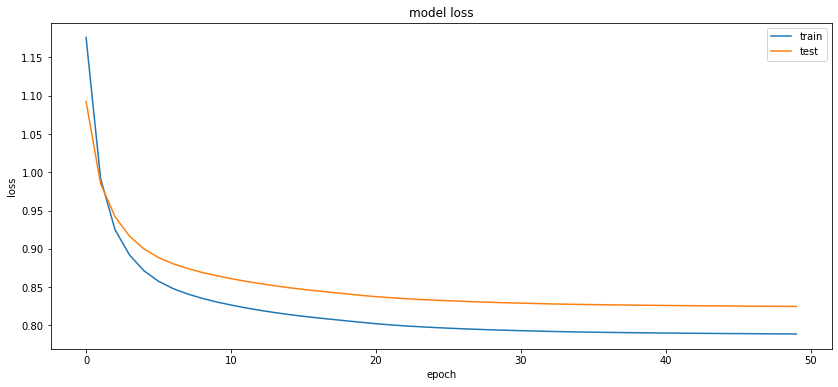

In [83]:
plot_loss_by_epoch(trainer)

Note: Testing error is on average higher since testing dataset contains abnormal instances but training data set contains only normal observations.

            reconstruction_error
true_class                      
0                       0.783167
1                      24.907437


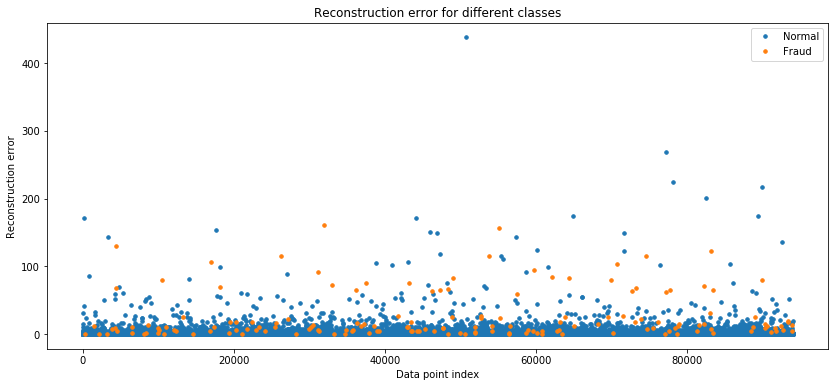

In [87]:
plot_reconstructuion_err_by_class(X_test, y_test, model = autoencoder)

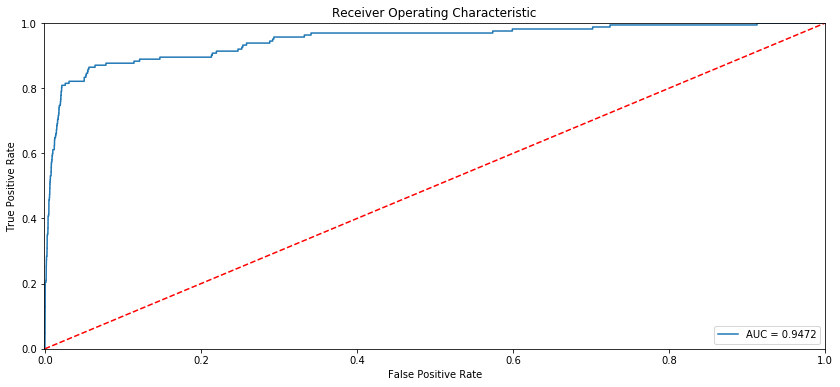

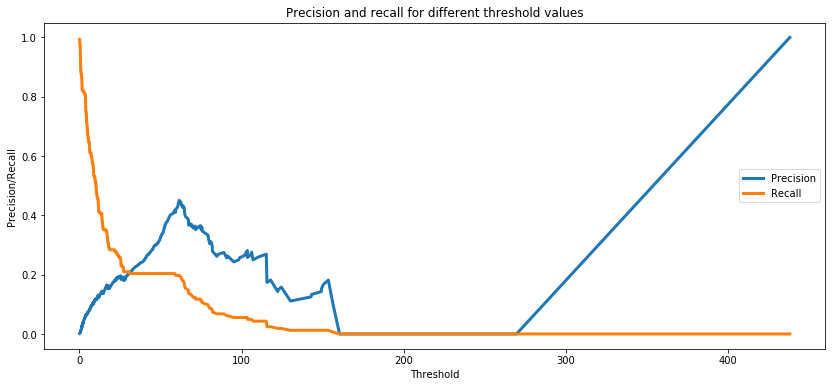

In [88]:
plot_precision_recall_curves(X_test, y_test, model = autoencoder)

## Using negative learning

Discriminative autoencoders aim at learning low-dimensional discriminative representations for positive (X+) and negative (X−) classes of data. The discriminative autoencoders build a latent space representation under the constraint that the positive data should be better reconstructed than the negative data. This is done by minimizing the reconstruction error for positive examples while ensuring that those of the negative class are pushed away from the manifold.


S. Razakarivony and F. Jurie, "Discriminative autoencoders for small targets detection," in Pattern Recognition (ICPR), 2014 <br />
ref: https://arxiv.org/pdf/1801.03149.pdf

In [46]:
import tensorflow.keras.backend as K

def negative_learn_loss(y_true, y_pred):
    (y_true, t) = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)
    return K.sum(K.maximum(t*(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1))-1), 0), axis=-1)

In the above loss function, t(x) = {−1,+1} denotes as the label of the sample.

We redifine the Class feature, using 1 for positive samples and -1 for negative samples

In [41]:
df_negative = df.copy()
df_negative['Class'] = df_negative['Class'].map({0: 1, 1:-1})

Now we train with both positive and negative samples

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_negative.drop(['Class'], axis=1), 
                                                    df_negative['Class'], 
                                                    test_size=0.33, 
                                                    stratify=df_negative['Class'],
                                                    random_state=42)

Our training data output now has the following shape, (X_train, y_train)

ref: https://stackoverflow.com/questions/57704771/inputs-to-eager-execution-function-cannot-be-keras-symbolic-tensors

In [43]:
X_train = X_train.to_numpy()
Xy_train = np.concatenate((X_train, y_train[:, None]), axis=1)

In [44]:
X_eval = X_test.to_numpy()
Xy_eval = np.concatenate((X_test, y_test[:, None]), axis=1)

Create the model

In [47]:
autoencoder_nl = Autoencoder(encoding_dim=10)
autoencoder_nl.compile(optimizer=tf.optimizers.Adam(lr=0.00025), loss=negative_learn_loss)

In [48]:
trainer_nl = autoencoder_nl.fit(x = X_train, 
                                y = Xy_train,
                                epochs=50,
                                validation_data=(X_eval, Xy_eval),
                                batch_size=256,
                                shuffle=True)

Train on 190820 samples, validate on 93987 samples
Epoch 1/50
190820/190820 [==============================] - 3s 13us/sample - loss: 1075.0847 - val_loss: 977.1289
Epoch 2/50
190820/190820 [==============================] - 2s 11us/sample - loss: 923.5158 - val_loss: 888.4934
Epoch 3/50
190820/190820 [==============================] - 2s 11us/sample - loss: 869.5655 - val_loss: 854.3929
Epoch 4/50
190820/190820 [==============================] - 2s 11us/sample - loss: 842.7418 - val_loss: 833.1063
Epoch 5/50
190820/190820 [==============================] - 2s 11us/sample - loss: 825.1978 - val_loss: 818.6005
Epoch 6/50
190820/190820 [==============================] - 2s 11us/sample - loss: 812.7914 - val_loss: 808.0734
Epoch 7/50
190820/190820 [==============================] - 2s 11us/sample - loss: 803.8149 - val_loss: 800.3051
Epoch 8/50
190820/190820 [==============================] - 2s 11us/sample - loss: 797.3560 - val_loss: 795.0228
Epoch 9/50
190820/190820 [==================

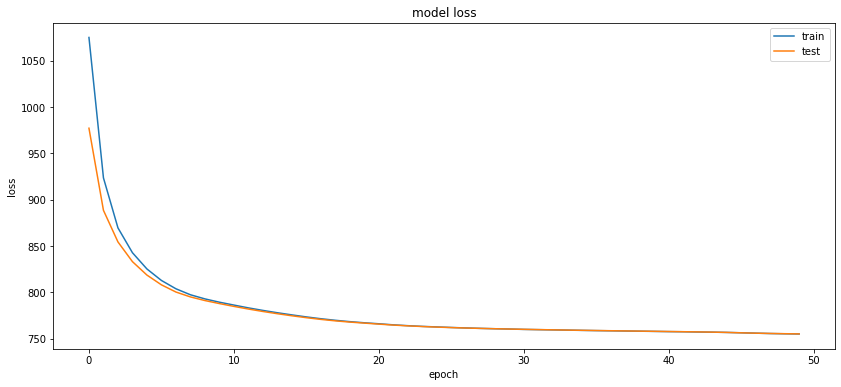

In [50]:
plot_loss_by_epoch(trainer_nl)

WARNING - Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


            reconstruction_error
true_class                      
-1                     27.435165
 1                      0.783327


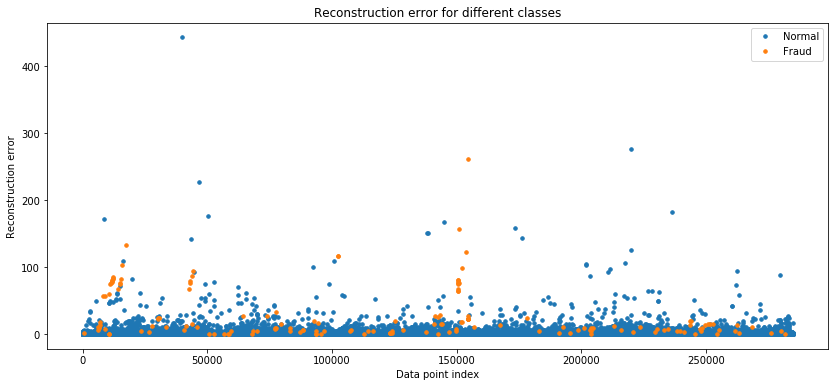

In [59]:
plot_reconstructuion_err_by_class(X_test, y_test.to_numpy(), model = autoencoder_nl, anomaly_class = -1)

WARNING - Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


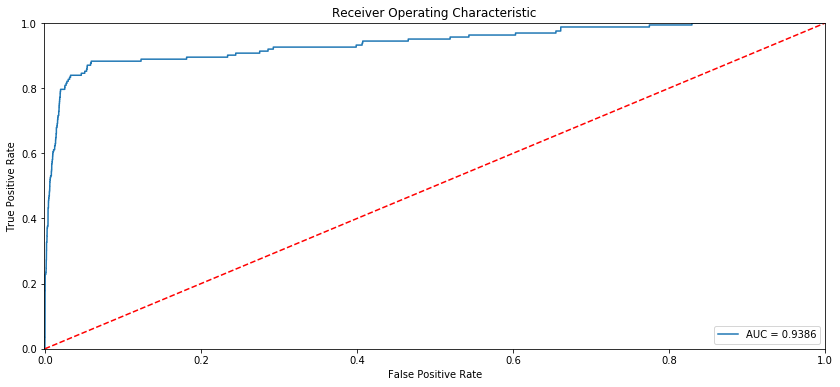

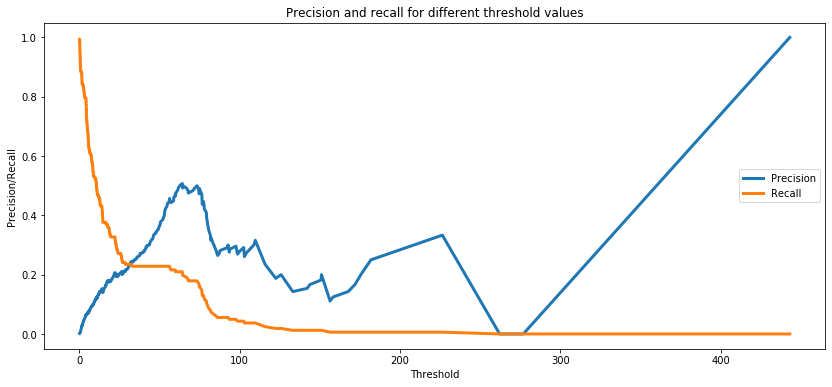

In [53]:
plot_precision_recall_curves(X_test, y_test, model = autoencoder_nl, anomaly_class = -1)